## MATH3041 Project
## Climate Model

### Importing and Compiling Data

In [433]:
%matplotlib notebook
#%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from ipywidgets import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#######################################################
########## Import/clean temperature data ##############
#######################################################
df_temp = pd.read_csv("Data/nasa_land-ocean_temp_index.txt", delim_whitespace=True)
df_temp['No_Smoothing'] = df_temp['No_Smoothing']+14.15
df_temp = df_temp[['Year','No_Smoothing']]
df_temp.columns = ['YEAR', 'TEMP']


#######################################################
#### Import/clean greenhouse gas concentration data ###
#######################################################
df_gg_1 = pd.read_csv("Data/ice_core_2006.txt", delim_whitespace=True)
df_gg_2 = pd.read_csv("Data/NOAA_MoleFractions_2022.csv")

df_gg_1 = df_gg_1[["YearAD", "CH4spl", "CO2spl","N2Ospl"]]
df_gg_2 = df_gg_2[["YEAR","CO2","CH4","N2O"]]
df_gg_2['YEAR'] = df_gg_2['YEAR']-0.5
df_gg_1.columns = ['YEAR', 'CH4', 'CO2', 'N2O']
#df_gg_1 ranges from 1-2004
#df_gg_2 ranges from 1979-2020
df_gg_2 = df_gg_2[df_gg_2['YEAR']>=2005]

#concat df_gg_2 from 2005 onwards onto the end of df_gg_1
df_gg = pd.concat([df_gg_1, df_gg_2], ignore_index=True)

# TODO: Maybe try averaging the values for the overlapping years since they aren't the same

co2_data = df_gg[['YEAR','CO2']]
ch4_data = df_gg[['YEAR','CH4']]
n2o_data = df_gg[['YEAR','N2O']]

#alternative numpy array approach
#co2_data = df_gg[['YEAR','CO2']].to_numpy()
#print(co2_data[:,0]) #years
#print(co2_data[:,1]) #values

#######################################################
########## Import/clean aerosol emission data #########
#######################################################
df_ae = pd.read_csv("Data/carbonator_scenario5_ed.csv",index_col=0, header=None).T
df_volc = df_ae[['volcanics_year','volcanics']]
df_volc.columns = ['YEAR', 'VOLC']
volc_data = df_volc

df_so2 = df_ae[['so2_year','so2']].dropna()
df_so2.columns = ['YEAR', 'SO2']

#We only have SO2 emission data for each decade, so we interpolate annual meqsurements
df_so2_interp = data=pd.DataFrame({'YEAR':[],'SO2':[]})
for i in range(len(df_so2)-1):
    x1 = df_so2.iloc[i]["YEAR"]
    x2 = df_so2.iloc[i+1]["YEAR"]    
    y1 = df_so2.iloc[i]["SO2"]
    y2 = df_so2.iloc[i+1]["SO2"]
    gradient = (y2-y1)/(x2-x1)
    for j in range(1,int(x2-x1)):
        x = x1+j
        y = gradient*x - gradient*x1 + y1 
        df_so2_interp = df_so2_interp.append({'YEAR':x, 'SO2': y}, ignore_index = True)

so2_data = pd.concat([df_so2, df_so2_interp], ignore_index=True)
so2_data = so2_data.sort_values(by=['YEAR'])


### Annual Emissions

<IPython.core.display.Javascript object>


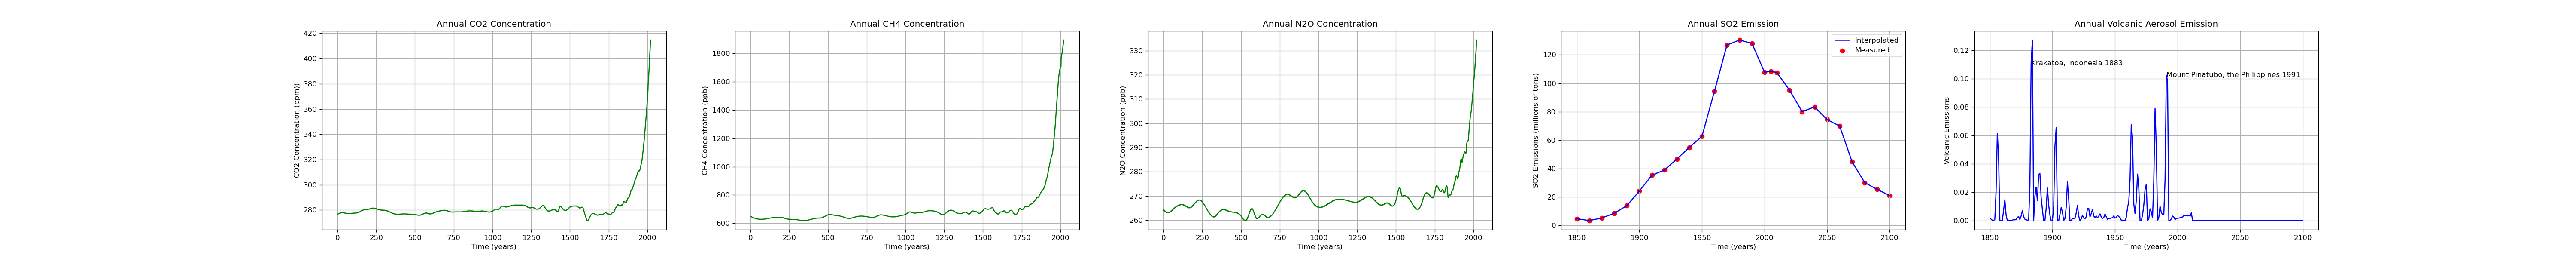

In [434]:
fig_em = plt.figure(figsize=(50, 5))
axe_co2 = fig_em.add_subplot(151)
axe_ch4 = fig_em.add_subplot(152)
axe_n2o = fig_em.add_subplot(153)
axe_so2 = fig_em.add_subplot(154)
axe_vol = fig_em.add_subplot(155)
#fig_em, (axe_co2, axe_ch4, axe_n2o, axe_so2, axe_vol) = plt.subplots(1, 5)
#fig_em(figsize=(15, 15))
#fig=plt.figure()
linee_co2, = axe_co2.plot(co2_data['YEAR'].tolist(), co2_data['CO2'].tolist(), color='g')
linee_ch4, = axe_ch4.plot(ch4_data['YEAR'].tolist(), ch4_data['CH4'].tolist(), color='g')
linee_n2o, = axe_n2o.plot(n2o_data['YEAR'].tolist(), n2o_data['N2O'].tolist(), color='g')
linee_so2, = axe_so2.plot(so2_data['YEAR'].tolist(), so2_data['SO2'].tolist(), color='b')
axe_so2.scatter(df_so2['YEAR'],df_so2['SO2'],c='r')
linee_vol, = axe_vol.plot(volc_data['YEAR'].tolist(), volc_data['VOLC'].tolist(), color='b')

axe_co2.set_title("Annual CO2 Concentration");axe_co2.set_xlabel("Time (years)");axe_co2.set_ylabel("CO2 Concentration (ppm))"); axe_co2.grid()
axe_ch4.set_title("Annual CH4 Concentration");axe_ch4.set_xlabel("Time (years)");axe_ch4.set_ylabel("CH4 Concentration (ppb)"); axe_ch4.grid()
axe_n2o.set_title("Annual N2O Concentration");axe_n2o.set_xlabel("Time (years)");axe_n2o.set_ylabel("N2O Concentration (ppb)"); axe_n2o.grid()
axe_so2.set_title("Annual SO2 Emission");axe_so2.set_xlabel("Time (years)");axe_so2.set_ylabel("SO2 Emissions (millions of tons)"); axe_so2.legend(["Interpolated","Measured"]); axe_so2.grid()
axe_vol.set_title("Annual Volcanic Aerosol Emission");axe_vol.set_xlabel("Time (years)");axe_vol.set_ylabel("Volcanic Emissions"); axe_vol.grid()
axe_vol.annotate("Krakatoa, Indonesia 1883", (1883, 0.110576), va='center')
axe_vol.annotate("Mount Pinatubo, the Philippines 1991", (1991, 0.102435), va='center')
plt.show()

### Define Climate Model Class and Greehouse Gas Classes

In [435]:
class climateModel:
    startTime = 1850 #Determines startTemp
    startTemp = 14.0 #Surface temperature at startTime
    startOTemp = 2.0 #Deep ocean temp at startTime
    temp = [] #contains simulated temperatures
    otemp = [] #contains simulated deep ocean temperatures
    time = [] #adds a year for each time step
    delta_t = 1 #change in time across each time step
    #Climate parameters:
    surfCap = 51.0 #9.0 #290000000 #heat capacity of the Earth/ocean surface: W/m^2/*C
    oceanCap = 106.0 #3340000000 #ocean heat capacity
    oceanFeedback = 0.73 
    solConst = 1368.0 #S_0: W/m^2
    albedo = 0.3
    climateFeedback = -1.3 #B
    climateInter = solConst*(1 - albedo)/4 + climateFeedback*startTemp; #A
    
    temps = {} #dictionary for temperature anomally due to each of radiative forcing factor
    
    #Can set all parameters, but uses above defaults
    def __init__(self, startTime=startTime, startTemp=startTemp, delta_t=delta_t, 
                 surfCap=surfCap, solConst=solConst, albedo=albedo, climateFeedback=climateFeedback, ggs=[], aos=[]):
        self.startTime = startTime
        self.startTemp = startTemp
        self.delta_t = delta_t
        self.surfCap = surfCap
        self.solConst = solConst
        self.albedo = albedo
        self.climateFeedback = climateFeedback
        self.climateInter = self.solConst*(1 - self.albedo)/4 + self.climateFeedback*self.startTemp;
        self.ggs = ggs #list of greenhouse gas objects
        self.aos = aos
        self.time = [self.startTime]
        self.temp = [self.startTemp]
        self.otemp = [self.startOTemp]
        self.sEnergy = []
        self.outEnergy = []
        self.temps = {"solar": [], "out": [], "co2": [], "ch4": [], "n2o": [], "volc": []}

class greenhouseGas:
    def __init__(self, forcingCoeff, startConc, data=pd.DataFrame([])):
        self.data = data #concentration data
        self.forcingCoeff = forcingCoeff 
        self.startConc = startConc #initial concentration at startTime
    def forcing(self,time):
        pass

class carbonDioxide(greenhouseGas):
    name = "CO2"
    startConc = 286.8 #CO2 concentration (ppm) for the default year 1850
    forcingCoeff = 5.35 #see: table 1 https://gml.noaa.gov/aggi/aggi.html
    energy = []
    def __init__(self, forcingCoeff=forcingCoeff, startConc=startConc, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, startConc, data)
        self.energy = [] #radiative forcing effect
    
    def forcing(self,time):
        #use real world data
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['CO2'].item()
        #use cubic extrapolation if no data provided:
        else:
            c_curr = self.startConc*(1 + ((time - 1850)/220)**3) #not sure about the 1850 stuff?
        return self.forcingCoeff*math.log(c_curr/self.startConc)

#for computing CH4 and N2O radiative forcing
#used in the table 1 of article: https://gml.noaa.gov/aggi/aggi.html
def gg_interaction(m,n):
    return 0.47 * math.log(1 + 2.01*(10**(-5))*(m*n)**0.75 + 5.31*(10**(-15))*m*(m*n)**1.52)
    
class methane(greenhouseGas):
    name = "CH4"
    startConc = 783.8 #CH4 concentration (ppb) for the default year 1850
    startConcN2O = 270.4 #N2O concentration (ppb) for the default year 1850
    forcingCoeff = 0.036 
    
    def __init__(self, forcingCoeff=forcingCoeff, startConc=startConc, startConcN2O=startConcN2O, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, startConc, data)
        self.energy = []
        self.startConcN2O = startConcN2O
    
    def forcing(self,time):
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['CH4'].item()
        #use initial concentration if no data provided
        #TODO: replace this with regression based extrapolation
        else:
            c_curr = self.startConc 
        if self.forcingCoeff == 0: return 0
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.startConc)) - (gg_interaction(c_curr,self.startConcN2O) - gg_interaction(self.startConc,self.startConcN2O))

class nitrousOxide(greenhouseGas):
    name = "N2O"
    startConc = 270.4 
    startConcCH4 = 783.8 
    forcingCoeff = 0.12
    
    def __init__(self, forcingCoeff=forcingCoeff, startConc=startConc, startConcCH4=startConcCH4, data=pd.DataFrame([])):
        super().__init__(forcingCoeff, startConc, data)
        self.startConcCH4 = startConcCH4
        self.energy = []        
    
    def forcing(self,time):
        if not self.data.empty and time in self.data['YEAR'].values:
            c_curr = self.data[self.data['YEAR']==time]['N2O'].item()
        #use initial concentration if no data provided
        #TODO: replace this with regression based extrapolation
        else:
            c_curr = self.c_0 
        if self.forcingCoeff == 0: return 0
        return self.forcingCoeff*(math.sqrt(c_curr) - math.sqrt(self.startConc)) - (gg_interaction(self.startConcCH4,c_curr) - gg_interaction(self.startConcCH4,self.startConc))

    
class aerosolGas:
    def __init__(self, startEmis, data=pd.DataFrame([])):
        self.data = data #concentration data
        self.startEmis = startEmis 
    def forcing(self,time,delta_t):
        pass

#tvolc, optThicknessVolc, cvolc, vol_en

    
class volcanic(aerosolGas):
    name = "Volcanic"
    startEmis = 0 
    cvolc = -20 #converts from optical thickness of volcanic aerosol emission to radiative forcing
    tvolc = 1.2 #decay timescale of volcanic aerosols in the upper atmosphere
    optThicknessVolc = [0]
    
    def __init__(self, startEmis=startEmis, data=pd.DataFrame([]), cvolc=cvolc, tvolc=tvolc):
        super().__init__(startEmis, data)
        optThicknessVolc = [self.startEmis]
        self.cvolc=cvolc
        self.tvolc=tvolc
        self.energy = []        
    
    def forcing(self,time,delta_t):
        if not self.data.empty and time in self.data['YEAR'].values:
            e_curr = self.data[self.data['YEAR']==time]['VOLC'].item()
        else:
            e_curr = 0
        #might not return 0 if current emission are 0 since we model time taken for emissions to fall from the atmosphere
        delta_optThick = self.optThicknessVolc[-1] + delta_t*(e_curr - (1/self.tvolc)*self.optThicknessVolc[-1])
        self.optThicknessVolc.append(delta_optThick)
               
        return self.cvolc*delta_optThick
    
class sulfurDioxide(aerosolGas):
    name = "SO2"
    startEmis = 4.54293 #million tons of sulphur dioxide in 1850
    cso2 = -0.0052 #conversion from emission to radiative forcing
    
    def __init__(self, startEmis=startEmis, data=pd.DataFrame([]), cso2=cso2):
        super().__init__(startEmis, data)
        self.cso2=cso2
        self.energy = []        
    
    def forcing(self,time,delta_t):
        if not self.data.empty and time in self.data['YEAR'].values:
            e_curr = self.data[self.data['YEAR']==time]['SO2'].item()
        else:
            e_curr = 0               
        return self.cso2*(e_curr - self.startEmis)
    
print("Classes compiled")

Classes compiled


### Define Functions to Run the Climate Simulation

In [436]:
def solar_energy_in(s, a):
    return s*(1 - a)/4

def energy_leaving_surface(T, A, B):
    return A - B * T

def human_aerosol_reflection(time):
    return -0.0052 * (df_so2[df_so2['YEAR']==time]['SO2'].item() - df_so2[df_so2['YEAR']==1880]['SO2'].item())
    #return k_h * mass of material emitted per second

def greenhouse_effect(ggs,time):
    ef = 0.0
    for g in ggs:
        f = g.forcing(time)
        ef = ef + f
        g.energy.append(f) #move this
    return ef
    
def aerosol_effect(aos,time,delta_t):
    ef = 0.0
    for a in aos:
        f = a.forcing(time,delta_t)
        ef = ef + f
        a.energy.append(f)
    return ef
    
def deep_ocean_transfer(surf_temp, ocean_temp, feedback):
    return 0
    #return feedback * (surf_temp - ocean_temp)

def tendency(model):
    model.sEnergy.append(solar_energy_in(model.solConst, model.albedo))
    model.outEnergy.append(-energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback))
    return (1/model.surfCap) * (solar_energy_in(model.solConst, model.albedo) \
            - energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback) \
            + aerosol_effect(model.aos, model.time[-1],model.delta_t) \
            + greenhouse_effect(model.ggs, model.time[-1])) \
            - deep_ocean_transfer(model.temp[-1], model.otemp[-1], model.oceanFeedback)
    
def ocean_tendency(model):
    return (1/model.surfCap) * deep_ocean_transfer(model.temp[-2], model.otemp[-1], model.oceanFeedback)

def timeStep(model):
    model.temp.append(model.temp[-1] + model.delta_t*tendency(model))
    #model.otemp.append(model.otemp[-1] + model.delta_t*ocean_tendency(model))
    #temp change for each forcing factor:
    model.temps['solar'].append(model.delta_t*(1/model.surfCap)*solar_energy_in(model.solConst, model.albedo))
    model.temps['out'].append(-model.delta_t*(1/model.surfCap)*energy_leaving_surface(model.temp[-1], model.climateInter, model.climateFeedback))
    model.temps['co2'].append(model.delta_t*(1/model.surfCap)*model.ggs[0].forcing(model.time[-1]))
    model.temps['ch4'].append(model.delta_t*(1/model.surfCap)*model.ggs[1].forcing(model.time[-1]))
    model.temps['n2o'].append(model.delta_t*(1/model.surfCap)*model.ggs[2].forcing(model.time[-1]))
    model.temps['volc'].append(model.delta_t*(1/model.surfCap)*model.aos[0].forcing(model.time[-1],model.delta_t))
    model.time.append(model.time[-1] + model.delta_t)

def runSimulation(model, end_year):
    while model.time[-1] < end_year:
        timeStep(model)
    print("Finished Simulation")
    print("Plotting Results")

### 1.1. Rate of change of surface temp due to changes in radiative forcing: Greenhouse Gases and Aerosols

Finished Simulation
Plotting Results


<IPython.core.display.Javascript object>


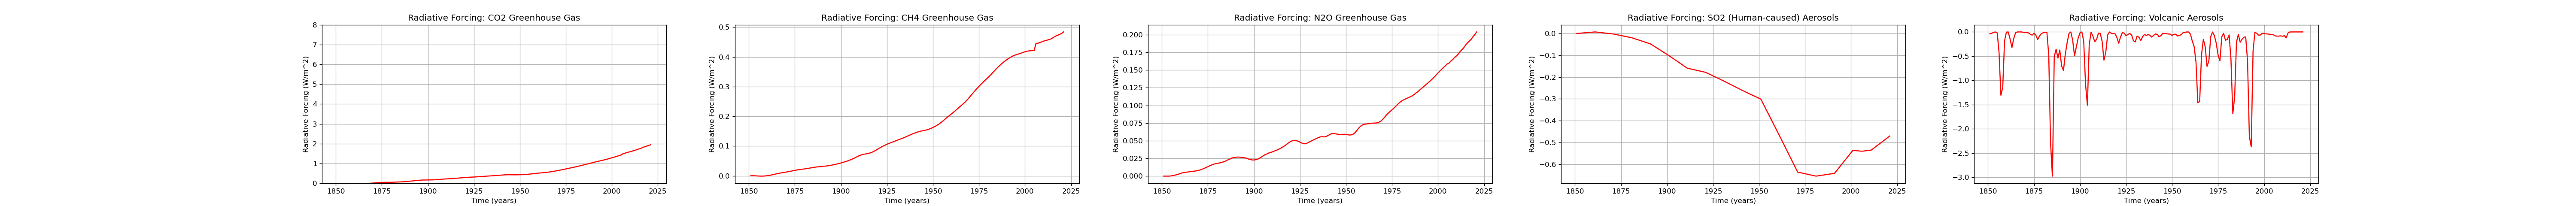

<IPython.core.display.Javascript object>


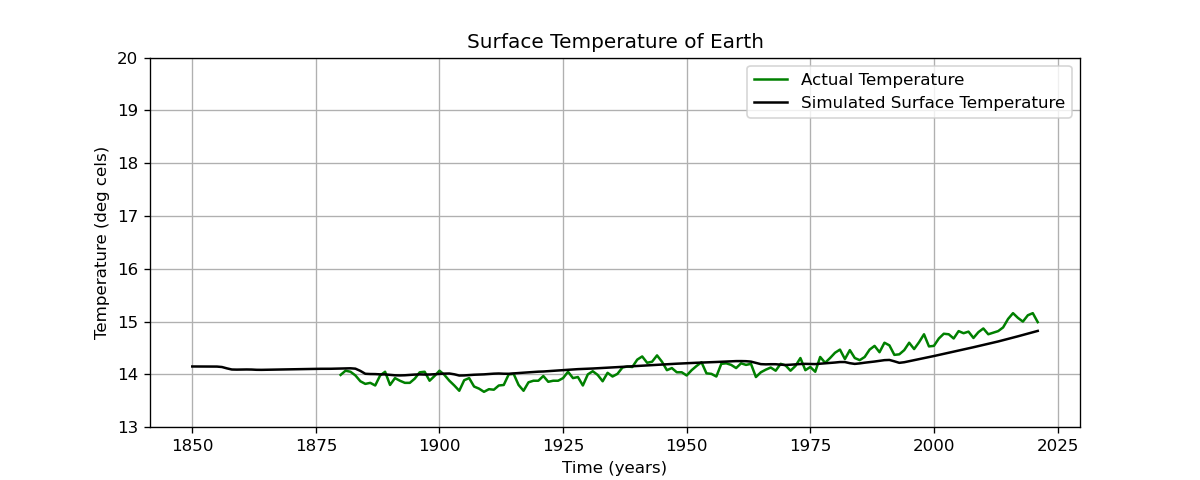

interactive(children=(FloatSlider(value=5.35, description='CO2_Forcing', max=20.0), FloatSlider(value=0.036, d…

<function __main__.update_surf(CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12, Volcanic_Forcing=-20, SO2_Forcing=True)>

In [441]:
#Set time interval for simulation, set initial values for real world data
startYear = 1850
endYear = 2021
co2_0 = co2_data[co2_data['YEAR']==startYear]['CO2'].item()
ch4_0 = ch4_data[ch4_data['YEAR']==startYear]['CH4'].item()
n2o_0 = n2o_data[n2o_data['YEAR']==startYear]['N2O'].item()
volc_0 = volc_data[volc_data['YEAR']==startYear]['VOLC'].item()
so2_0 = so2_data[so2_data['YEAR']==startYear]['SO2'].item()
t_0 = 14.15
#df_temp data only contains temperatures from 1880-, uncomment this line if startYear >=1880:
#t_0 = df_temp[df_temp['YEAR']==startYear]['TEMP'].item()


#Init greenhouse gas objects
co2_data = co2_data[co2_data['YEAR']>=startYear]
co2 = carbonDioxide(data=co2_data, startConc = co2_0)
ch4_data = ch4_data[ch4_data['YEAR']>=startYear]
ch4 = methane(data=ch4_data, startConc = ch4_0, startConcN2O = n2o_0)
n2o_data = n2o_data[n2o_data['YEAR']>=startYear]
n2o = nitrousOxide(data=n2o_data, startConc = n2o_0, startConcCH4 = ch4_0)


#Init aerosol objects
volc_data = volc_data[volc_data['YEAR']>=startYear]
volc = volcanic(data=volc_data, startEmis = volc_0)
so2_data = so2_data[so2_data['YEAR']>=startYear]
so2 = sulfurDioxide(data=so2_data, startEmis = so2_0)

#Init and run climate model
mod = climateModel(ggs=[co2,ch4,n2o], aos=[volc,so2], startTime=startYear, startTemp = t_0)
runSimulation(mod, endYear)


fig_rf = plt.figure(figsize=(50, 4))
axf_co2 = fig_rf.add_subplot(151)
axf_ch4 = fig_rf.add_subplot(152)
axf_n2o = fig_rf.add_subplot(153)
axf_so2 = fig_rf.add_subplot(154)
axf_vol = fig_rf.add_subplot(155)


#Plot CO2 radiative forcing
linef_co2, = axf_co2.plot(mod.time[1:], co2.energy, color='r')
axf_co2.set_title("Radiative Forcing: CO2 Greenhouse Gas");axf_co2.set_xlabel("Time (years)");axf_co2.set_ylabel("Radiative Forcing (W/m^2)");axf_co2.grid()
#Plot CH4 radiative forcing
linef_ch4, = axf_ch4.plot(mod.time[1:], ch4.energy, color='r')
axf_ch4.set_title("Radiative Forcing: CH4 Greenhouse Gas");axf_ch4.set_xlabel("Time (years)");axf_ch4.set_ylabel("Radiative Forcing (W/m^2)");axf_ch4.grid()
#Plot N2O radiative forcing
linef_n2o, = axf_n2o.plot(mod.time[1:], n2o.energy, color='r')
axf_n2o.set_title("Radiative Forcing: N2O Greenhouse Gas");axf_n2o.set_xlabel("Time (years)");axf_n2o.set_ylabel("Radiative Forcing (W/m^2)");axf_n2o.grid()
#Plot SO2 radiative forcing
linef_so2, = axf_so2.plot(mod.time[1:], so2.energy, color='r')
axf_so2.set_title("Radiative Forcing: SO2 (Human-caused) Aerosols");axf_so2.set_xlabel("Time (years)");axf_so2.set_ylabel("Radiative Forcing (W/m^2)");axf_so2.grid()
#Plot volcanic radiative forcing
linef_volc, = axf_vol.plot(mod.time[1:], volc.energy, color='r')
axf_vol.set_title("Radiative Forcing: Volcanic Aerosols");axf_vol.set_xlabel("Time (years)");axf_vol.set_ylabel("Radiative Forcing (W/m^2)");axf_vol.grid()

#Interactive plot of surface temperature
figt = plt.figure(figsize=(10, 4))
axt = figt.add_subplot(1, 1, 1)
line_realt, = axt.plot(df_temp['YEAR'].tolist(), df_temp['TEMP'].tolist(), color='g')
line_simt, = axt.plot(mod.time, mod.temp, color='k')
axt.set_title("Surface Temperature of Earth");axt.set_xlabel("Time (years)");axt.set_ylabel("Temperature (deg cels)")
axt.legend(["Actual Temperature", "Simulated Surface Temperature"]);axt.grid()


#box_layout = Layout(display='flex', flex_flow='row', justify_content='space-between', align_items='center')
#display(HBox([w.children[1],w.children[0]], layout=box_layout))

def update_surf(CO2_Forcing=5.35, CH4_Forcing=0.036, N2O_Forcing=0.12, Volcanic_Forcing=-20, SO2_Forcing=True):
    co2u = carbonDioxide(data=co2_data, forcingCoeff=CO2_Forcing)
    ch4u = methane(data=ch4_data, forcingCoeff=CH4_Forcing)
    n2ou = nitrousOxide(data=n2o_data, forcingCoeff=N2O_Forcing)
    volcu = volcanic(data=volc_data, startEmis = volc_0, cvolc=Volcanic_Forcing)
    so2u = sulfurDioxide(data=so2_data, startEmis = so2_0, cso2=(-0.0052 if SO2_Forcing else 0))
    modu = climateModel(ggs=[co2u,ch4u,n2ou],aos=[volcu,so2u], startTime=startYear, startTemp = t_0)
    
    runSimulation(modu, endYear)
    
    
    global linef_co2, linef_ch4, linef_n2o, linef_so2, linef_volc, line_simt
    axt.lines.remove(axt.lines[1])
    axf_co2.lines.remove(axf_co2.lines[0]); axf_ch4.lines.remove(axf_ch4.lines[0]);axf_n2o.lines.remove(axf_n2o.lines[0])
    axf_so2.lines.remove(axf_so2.lines[0]);axf_vol.lines.remove(axf_vol.lines[0]);
    
    line_simt = axt.plot(modu.time, modu.temp, color='k')
    linef_co2, = axf_co2.plot(modu.time[1:], co2u.energy,color='r')
    linef_ch4, = axf_ch4.plot(modu.time[1:], ch4u.energy, color='r')
    linef_n2o, = axf_n2o.plot(modu.time[1:], n2ou.energy, color='r')
    linef_so2, = axf_so2.plot(modu.time[1:], so2u.energy, color='r')
    linef_volc, = axf_vol.plot(modu.time[1:], volcu.energy, color='r')
        
    axf_co2.set_ylim(0,8)
    axt.set_ylim(13,20)
    plt.show()

interact(update_surf, CO2_Forcing = (0,20,0.1), CH4_Forcing=(0,5,0.001), N2O_Forcing=(0,5,0.01), Volcanic_Forcing=(-50,0,1), SO2_Forcing=True)

Script
> Show how simulated temperature approximates actual temperature

> Show that the temperature increases as we increase greenhouse gas forcing coefficients such as CO2

> Show that the temperature decreases as we decrease aerosol forcing coefficients such as volcanic

> Set all forcing coefficients to 0 to show how we get an energy balance and stable equilibrium temperature

### 1.2. Rate of change of surface temp due to changes in radiative forcing: Heat Capacity and Climate Feedback

Finished Simulation
Plotting Results


<IPython.core.display.Javascript object>


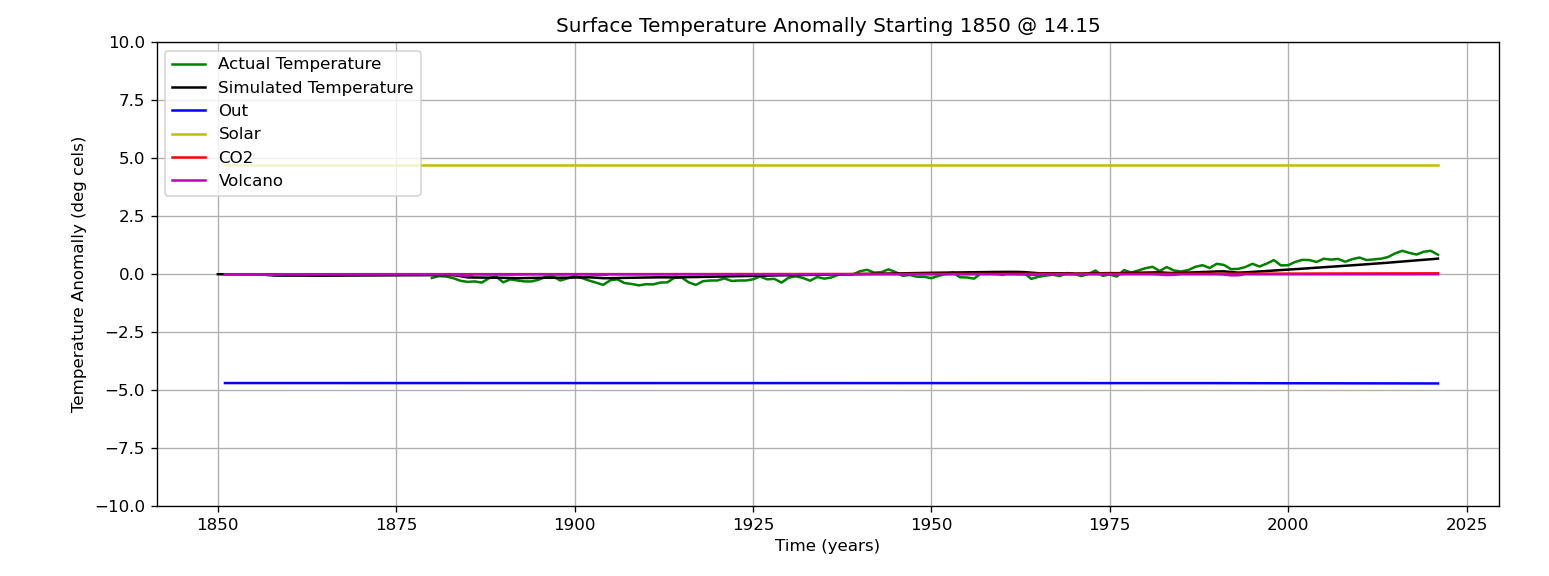

interactive(children=(FloatSlider(value=-1.3, description='Climate_feedback', max=10.0, min=-10.0), IntSlider(…

<function __main__.update_surf(Climate_feedback=-1.3, Surface_Heat_Capacity=51.0, Albedo=0.3)>

In [438]:
#Set time interval for simulation, set initial values for real world data
startYear = 1850
endYear = 2021
co2_0 = co2_data[co2_data['YEAR']==startYear]['CO2'].item()
ch4_0 = ch4_data[ch4_data['YEAR']==startYear]['CH4'].item()
n2o_0 = n2o_data[n2o_data['YEAR']==startYear]['N2O'].item()
volc_0 = volc_data[volc_data['YEAR']==startYear]['VOLC'].item()
so2_0 = so2_data[so2_data['YEAR']==startYear]['SO2'].item()
#t_0 = df_temp[df_temp['YEAR']==startYear]['TEMP'].item()
t_0 = 14.15

#Init greenhouse gas objects
co2_data = co2_data[co2_data['YEAR']>=startYear]
co2 = carbonDioxide(data=co2_data, startConc = co2_0)
ch4_data = ch4_data[ch4_data['YEAR']>=startYear]
ch4 = methane(data=ch4_data, startConc = ch4_0, startConcN2O = n2o_0)
n2o_data = n2o_data[n2o_data['YEAR']>=startYear]
n2o = nitrousOxide(data=n2o_data, startConc = n2o_0, startConcCH4 = ch4_0)

#Init aerosol objects
volc_data = volc_data[volc_data['YEAR']>=startYear]
volc = volcanic(data=volc_data, startEmis = volc_0)
so2_data = so2_data[so2_data['YEAR']>=startYear]
so2 = sulfurDioxide(data=so2_data, startEmis = so2_0)

#Init and run climate model
mod = climateModel(ggs=[co2,ch4,n2o], aos=[volc,so2], startTime=startYear, startTemp = t_0)
runSimulation(mod, endYear)


# Interactive plot of temperature anomally
figa = plt.figure()
axa = figa.add_subplot(1, 1, 1)
line_reala, = axa.plot(df_temp['YEAR'].tolist(), (df_temp['TEMP']-14.15).tolist(), color='g')
line_sima, = axa.plot(mod.time, [t - mod.startTemp for t in mod.temp], color='k')
line_outa, = axa.plot(mod.time[1:], mod.temps['out'], color='b')
line_sola, = axa.plot(mod.time[1:], mod.temps['solar'], color='y')
line_co2a, = axa.plot(mod.time[1:], mod.temps['co2'], color='r')
line_volca, = axa.plot(mod.time[1:], mod.temps['volc'], color='o')
axa.set_title("Surface Temperature Anomally Starting {} @ {}".format(startYear, t_0))
axa.set_xlabel("Time (years)")
axa.set_ylabel("Temperature Anomally (deg cels)")
#figa.subplots_adjust(bottom=0.3)
figa.tight_layout()
axa.legend(["Actual Temperature", "Simulated Surface Temperature","Out", "Solar", "CO2","Volcano"])
axa.grid()


def update_surf(Climate_feedback=-1.3, Surface_Heat_Capacity=51.0, Albedo=0.3):
    modu = climateModel(ggs=[co2,ch4,n2o],aos=[volc,so2], startTime=startYear, startTemp = t_0,
                        climateFeedback=Climate_feedback, surfCap=Surface_Heat_Capacity, albedo=Albedo)
    runSimulation(modu, endYear)
    
    global line_simt, line_sima, line_outa, line_sola, line_co2a, line_volca
    [axa.lines.remove(x) for x in axa.lines[1:]]
    #line_simt.remove()
    #line_sima.remove()
    #line_outa.remove()
    #line_co2a.remove()
    #linef_co2.remove()
    #linef_ch4.remove()
    #linef_n2o.remove()
    
    #axt.lines.remove(axt.lines[1])
    #axf_co2.lines.remove(axf_co2.lines[0])
    #axf_ch4.lines.remove(linef_ch4)
    #axf_n2o.lines.remove(linef_n2o)
    #[axa.lines.remove(l) for l in [line_sima, line_outa, line_sola, line_co2a]]
    line_sima = axa.plot(modu.time, [t - modu.startTemp for t in modu.temp], color='k')
    line_outa, = axa.plot(modu.time[1:], modu.temps['out'], color='b')
    line_sola, = axa.plot(modu.time[1:], modu.temps['solar'], color='y')
    line_co2a, = axa.plot(modu.time[1:], modu.temps['co2'], color='r')
    line_volca, = axa.plot(modu.time[1:], modu.temps['volc'], color='m')
    axa.legend(["Actual Temperature", "Simulated Temperature","Out", "Solar", "CO2","Volcano"])
    
    axa.set_ylim(-10,10)
    plt.show()

interact(update_surf, Climate_feedback = (-10.0,10.0,0.1), Surface_Heat_Capacity = (1,100,1), Albedo=(0,1,0.1))

Script
>Albedo: albedo should be thought of as being dependent on temperature, as lower temperature causes more ice formations which causes more reflection incoming solar radiation. But we've just modeled this as a constant because albedo only changes significantly over very long stretches of time, 1000s of years. So changing albedo will only change the amount of constant incoming solar radiation and consequently the amount of blackbody emission which is emitted.

> Surface Heat Capacity affects how sensitive the Earth's temperature is to any changes in radiative forcings. Increasing this value decreases the overall rate of temperature change caused by greenhouse gas and aerosols inbalances. This is because the Earth requires more heat in order to change temperature when the heat capacity is greater. When we decrease heat capacity, the Earth is much more sensitive to radiative forcings in the short term. We can visualize this is by setting the heat capacity to 1 and albedo to 0.99. The we can see that the temperature decreases sharply in the short term after volcanic erruptions.

> At the moment the only feedback term in this model is climateFeedback. It determines how efficiently the Earth is able to emit heat energy. To demonstrate what the climateFeedback is doing I'll set the heat capacity to 5 (making the system more sensitive to any radiative forcing) and then set the albedo to 0.9 to scale down the amount of constant incoming radiative forcings and help us see the effect of perturbations to the energy balance. If we set the climatefeedback to -0.01, then the system becomes more unstable in the long run as it takes more time for the temperature to return to equilibrium after volcanic erruptions and constant increase of greenhouse gas emissions forces temperature to very quickly increase indefinitely. If we set the climateFeedback to -7 or -8 we can see that temperature returns to equilibrium very quickly after volcanic erruptions, and slowly increases due to greenhouse gases. The climateFeedback is a negative feedback as this allows for stable energy balance model. If we set the climateFeedback to a positive value, say 1.0, then the temperature will become unstable very quickly. You might be wondering, now that we have a positive feedback, why is the temperature decreasing as opposed to increasing. This is because the first volcanic erruption in the data set causes the temperature to dip? If we start the simulation at the year 2000 then a positive climate feedback will cause tempt o Not sure about this


